# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                            log_loss)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=10, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

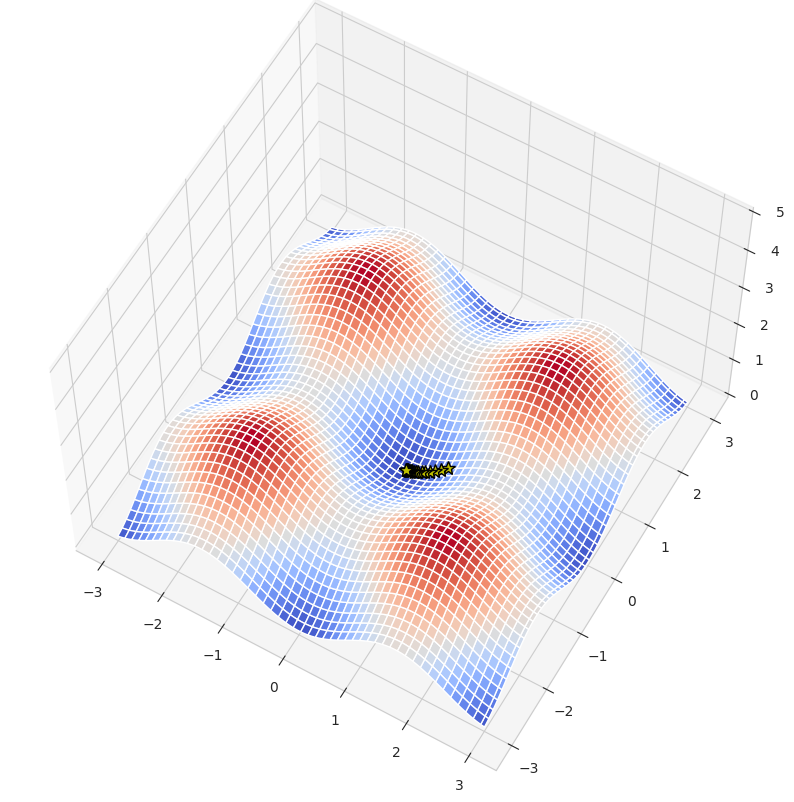

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

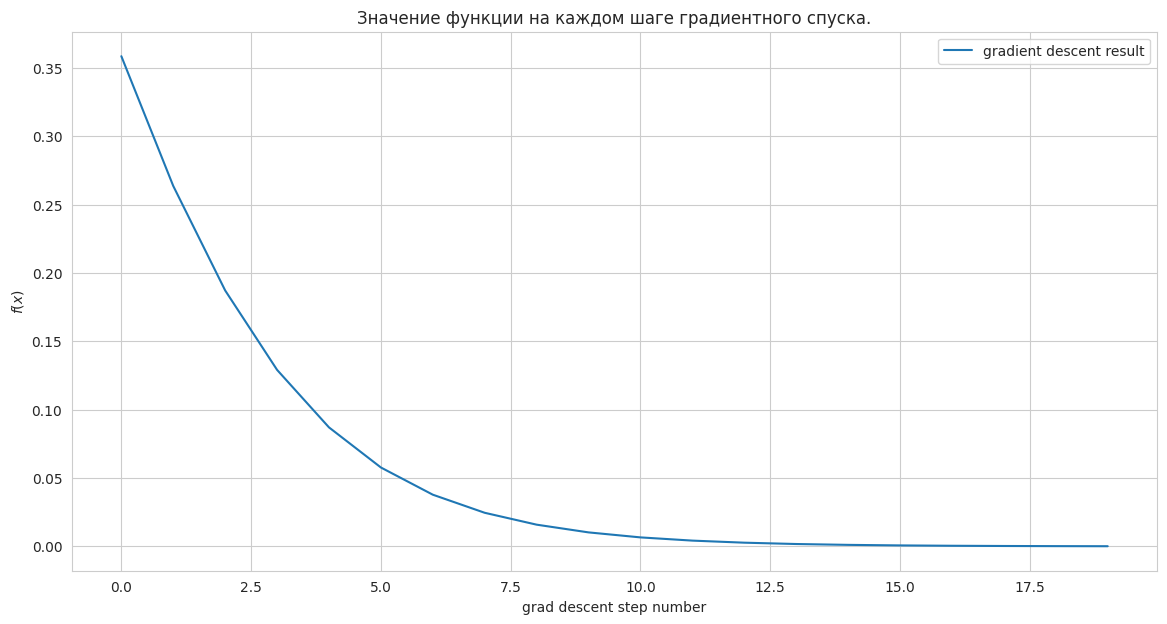

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    y_diff = y_true - y_pred
    n_samples = y_true.shape[0]
    mse = (np.transpose(y_diff) @ y_diff) / n_samples
    return mse
    


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n_samples = y_true.shape[0]
    mse_grad = 2 * (np.transpose(X) @ (y_pred - y_true)) / n_samples
    return mse_grad

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            y_pred = (X_test @ self.W).reshape(-1, 1)
            
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

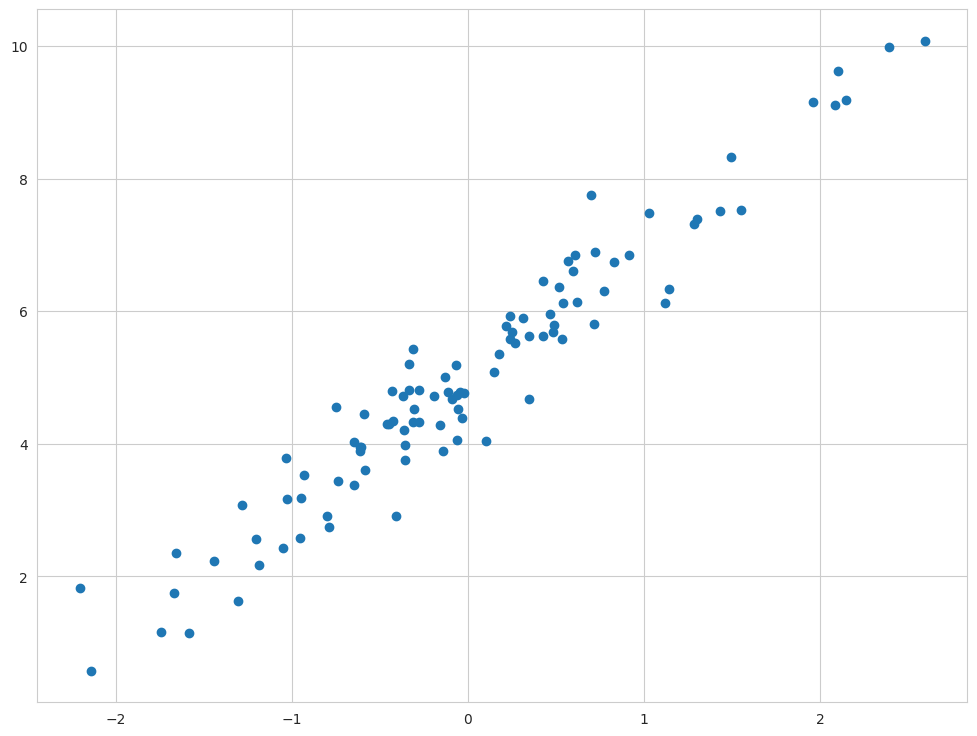

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

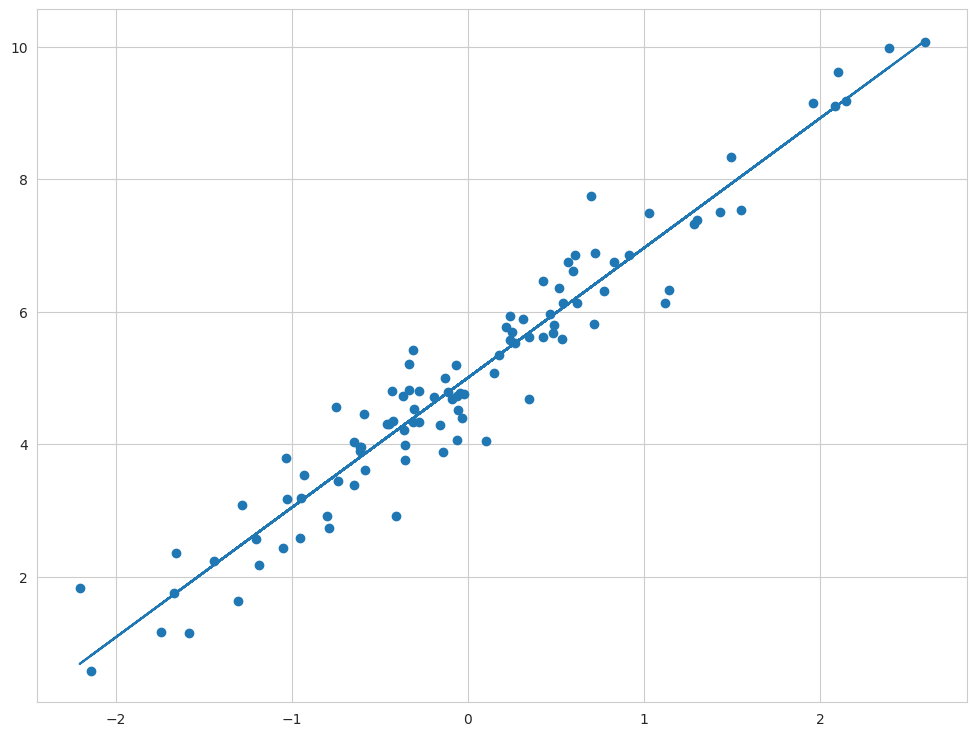

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
data = pd.concat([X, y], axis=1)

Ваш ход:

e2-e4
Точнее, ED(v)A-(ECHETYRE)

In [20]:
# Посмотрим на данные
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [21]:
# Посмотрим на данные под иным углом
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [22]:
# Базовые описательные статистики
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [23]:
# Ищем и считаем пропущенные значения
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [24]:
# Проверим, совпадает ли количество наблюдений у целевой переменной и признаков
X.shape[0] == y.shape[0]

True

Делим данные на тренировочную и тестовую выборку

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

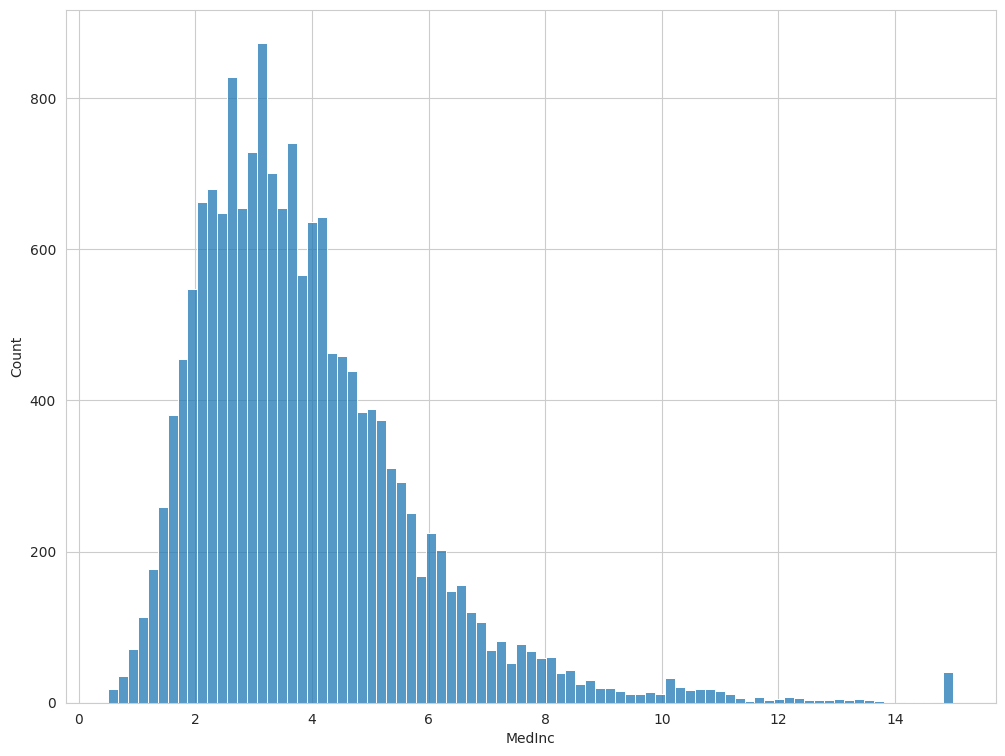

In [26]:
sns.histplot(data=X_train, x="MedInc");

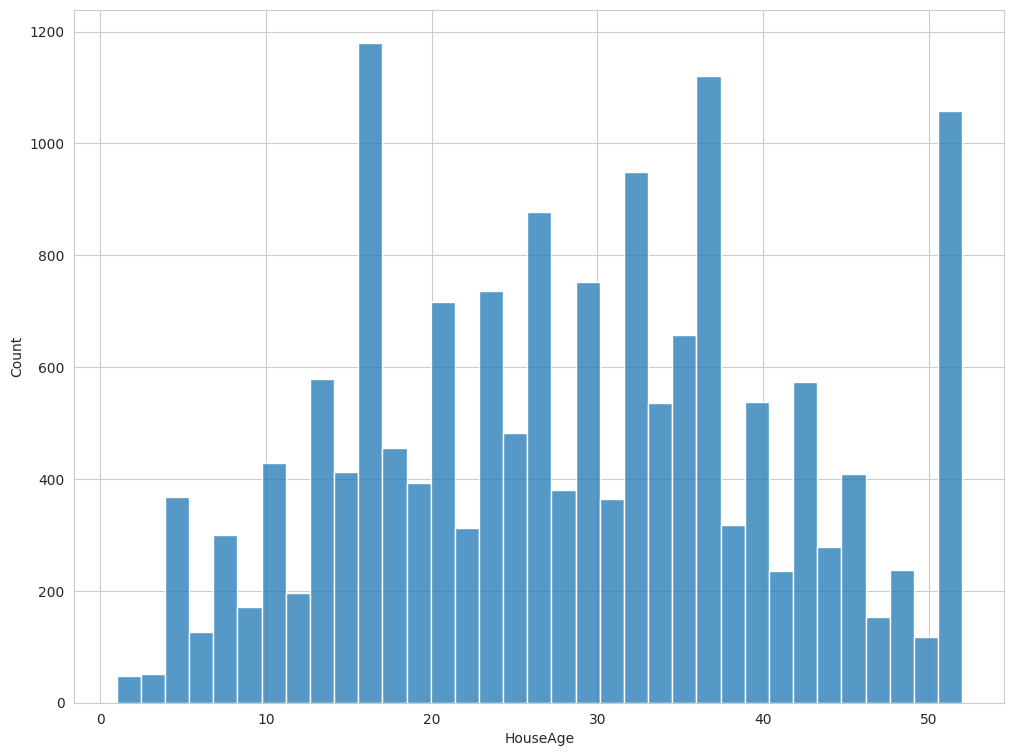

In [27]:
sns.histplot(data=X_train, x="HouseAge");

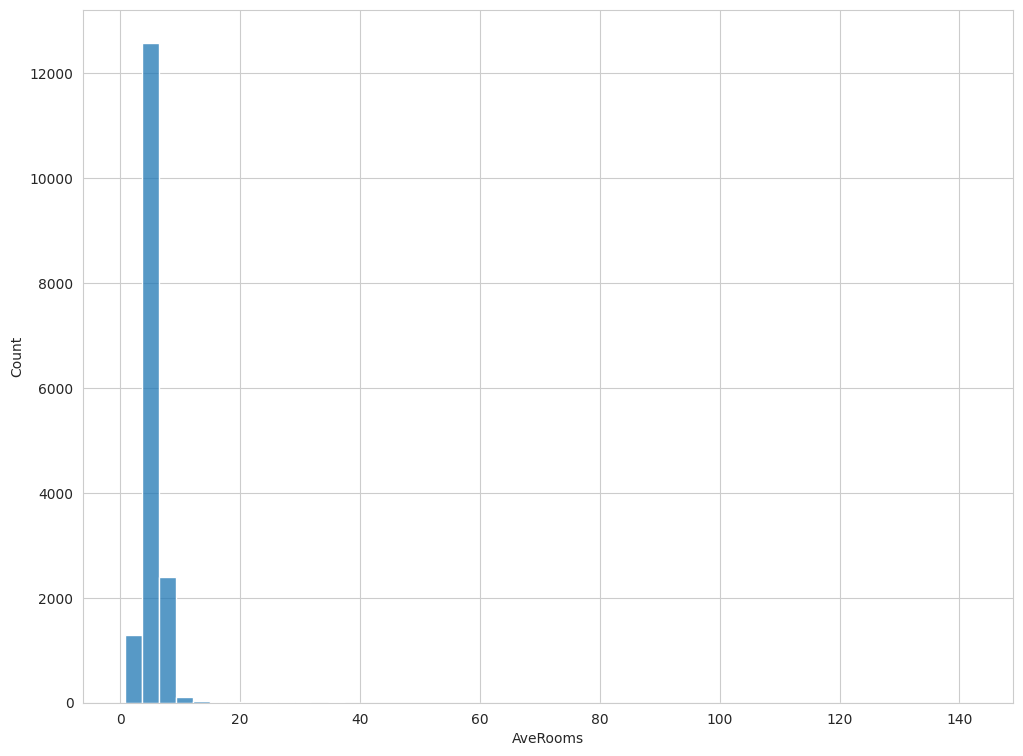

In [28]:
sns.histplot(data=X_train, x="AveRooms", bins=50);

Впечатление, что есть группа домов с очень большим числом комнат.
Проверим.

In [29]:
X_train.query("AveRooms > 30")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
3086,1.4205,28.0,31.062500,8.500000,98.0,2.041667,35.72,-118.59
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06
10080,3.4792,8.0,36.478261,6.304348,291.0,2.530435,39.35,-120.24
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54
9683,3.2917,10.0,34.571429,7.022321,483.0,2.156250,37.63,-118.99
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16
20094,2.1250,26.0,37.063492,7.185185,416.0,2.201058,38.19,-120.03


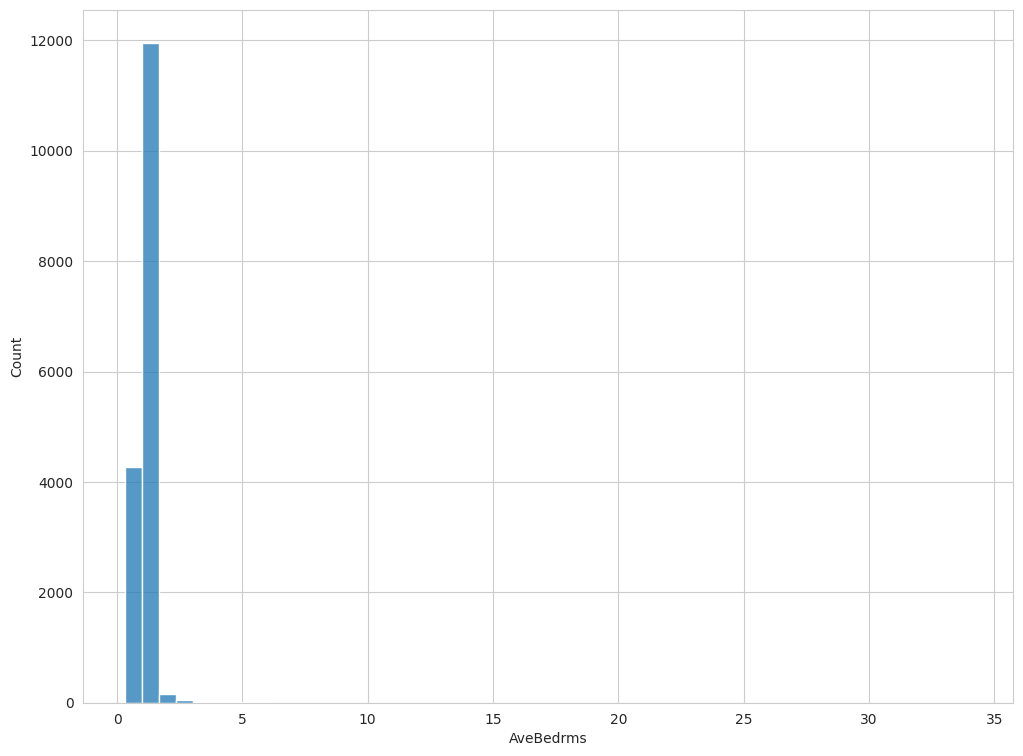

In [30]:
sns.histplot(data=X_train, x="AveBedrms", bins=50);

In [31]:
X_train.query("AveBedrms > 5")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
3086,1.4205,28.0,31.062500,8.500000,98.0,2.041667,35.72,-118.59
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06
10080,3.4792,8.0,36.478261,6.304348,291.0,2.530435,39.35,-120.24
19975,2.1029,11.0,23.994152,5.157895,356.0,2.081871,36.12,-118.54
13966,3.5104,29.0,26.465969,5.424084,410.0,2.146597,34.30,-116.99
13973,2.5147,11.0,22.133588,5.828244,713.0,2.721374,34.24,-116.82
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54
12344,2.1042,16.0,24.500000,6.071429,29.0,2.071429,33.82,-116.50


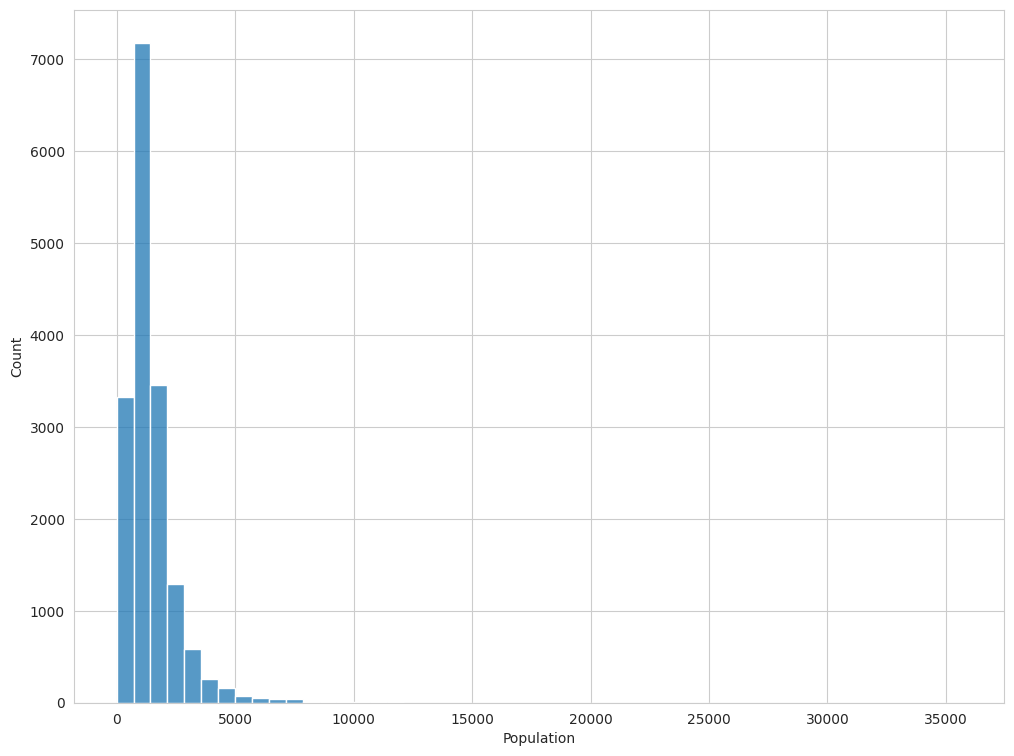

In [33]:
sns.histplot(data=X_train, x="Population", bins=50);

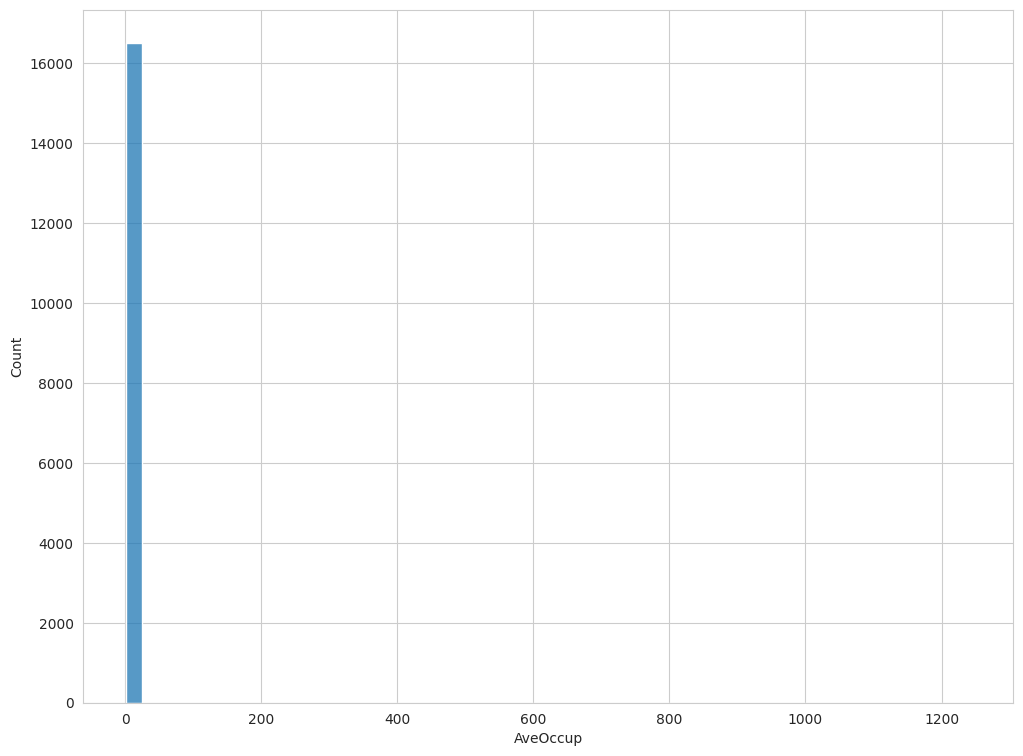

In [34]:
# Поменять толщину столбика
sns.histplot(data=X_train, x="AveOccup", bins=50);

In [35]:
X_train.query("AveOccup > 20")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70
13366,4.2578,36.0,5.258824,1.117647,2886.0,33.952941,33.94,-117.63
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33
5986,1.8750,52.0,4.500000,1.206349,2688.0,21.333333,34.10,-117.71
8874,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51


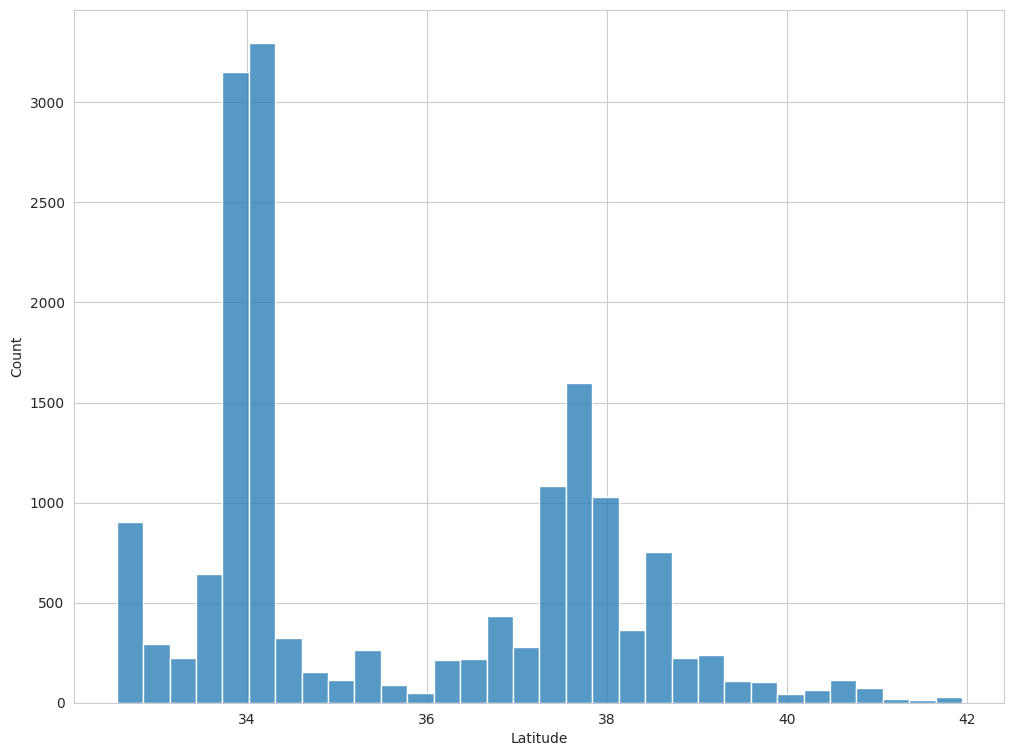

In [36]:
sns.histplot(data=X_train, x="Latitude");

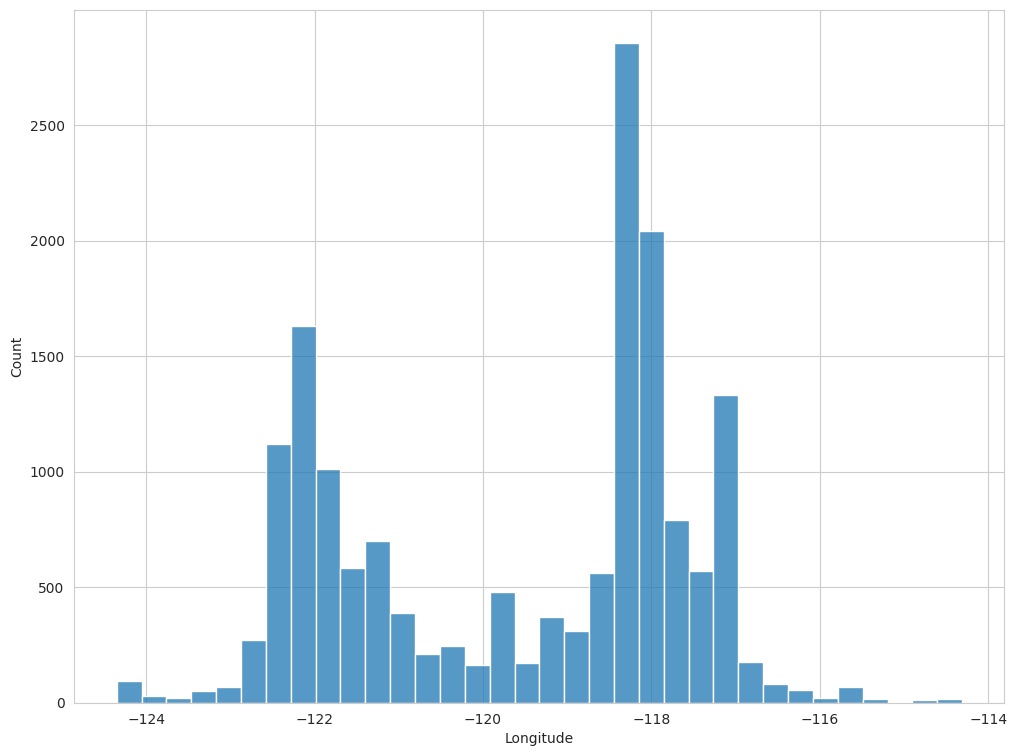

In [37]:
sns.histplot(data=X_train, x="Longitude");

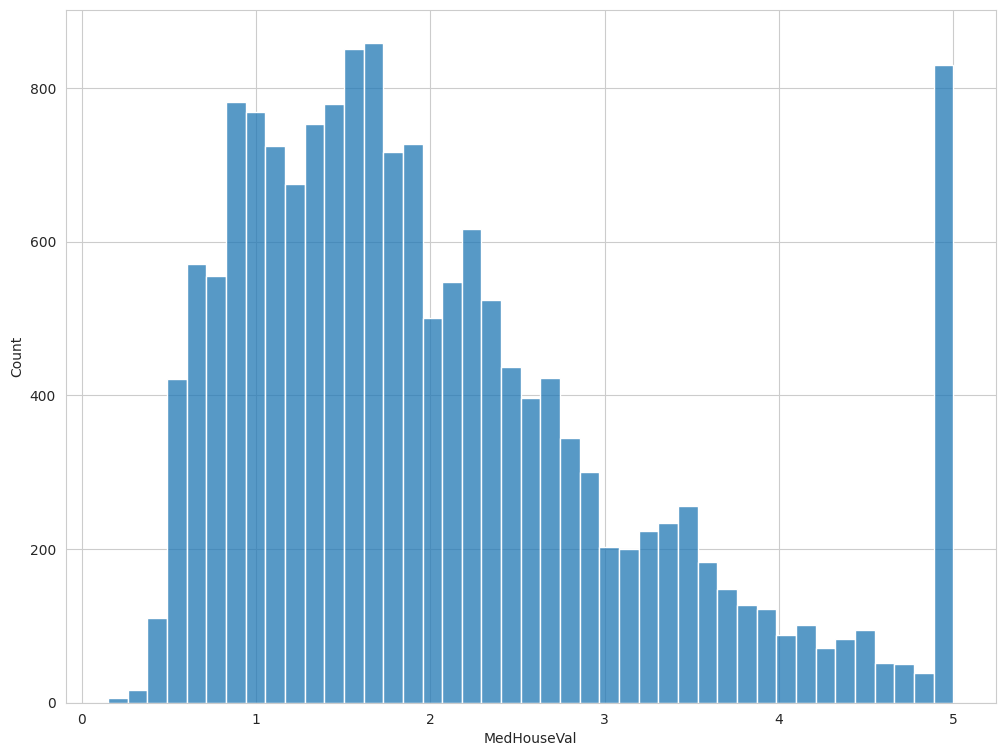

In [38]:
sns.histplot(y_train);

Заметно, что есть группа блоков, с аномально высокими ценами на дома. Возможно, это дома на побережье. Вероятно, имеет смысл разделить датасет на две части, и тренировать логистическую регрессию отдельно на домах со стандартной ценой и с большой ценой. Наличие большого числа домов с одинаковой ценой может означать некий законодательно регулируемый потолок цен на недвижимость.

Преобразовывать возраст дома в фактор не планирую (лекция из первого семестра заспойлерила этот момент).

In [39]:
# Насколько сильно переменные скоррелированы
X_train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119824,0.310043,-0.062500,0.008608,0.021777,-0.080476,-0.014962
HouseAge,-0.119824,1.000000,-0.142722,-0.069244,-0.295119,0.015067,0.008660,-0.104869
AveRooms,0.310043,-0.142722,1.000000,0.859841,-0.071119,-0.004217,0.106408,-0.027215
AveBedrms,-0.062500,-0.069244,0.859841,1.000000,-0.065808,-0.005614,0.070167,0.011609
Population,0.008608,-0.295119,-0.071119,-0.065808,1.000000,0.074041,-0.102467,0.092754
AveOccup,0.021777,0.015067,-0.004217,-0.005614,0.074041,1.000000,0.005323,-0.000006
Latitude,-0.080476,0.008660,0.106408,0.070167,-0.102467,0.005323,1.000000,-0.924154
Longitude,-0.014962,-0.104869,-0.027215,0.011609,0.092754,-0.000006,-0.924154,1.000000


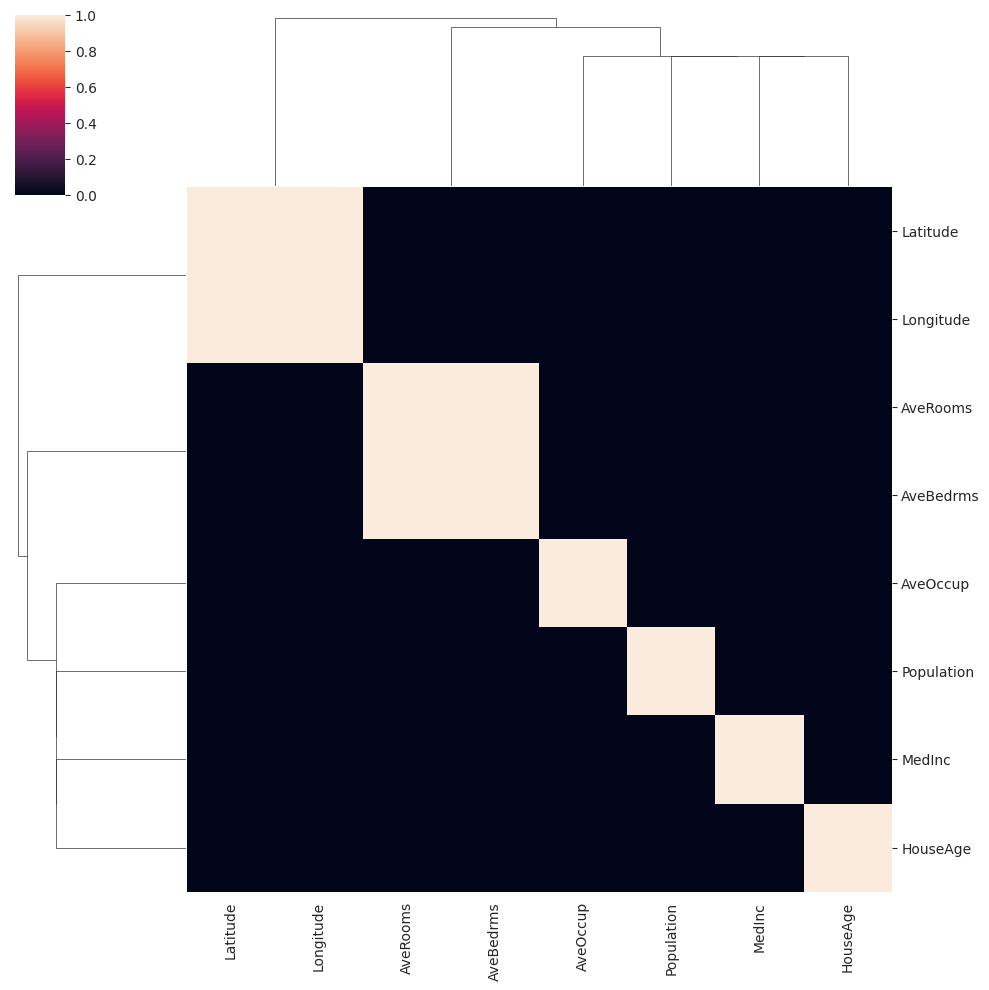

In [40]:
# Выделим переменные, у которых коэффициент корреляции больше, чем 0.5
sns.clustermap(X_train.corr().abs()>0.5);

Заметно, что сильно коррелируют широта и долгота (вследствие географической специфики Калифорнии) а также среднее число комнат и среднее число спален. Засим предложено при первой возможности убрать из числа предикторов среднее число спален и долготу.

Делим на две подвыборки.

In [41]:
data_exp = data.query("MedHouseVal > 5")
X_exp = data_exp.loc[:, data_exp.columns != "MedHouseVal"]
y_exp = data_exp.loc[:, "MedHouseVal"]
data_cheap = data.query("MedHouseVal < 5")
X_cheap = data_cheap.loc[:, data_cheap.columns != "MedHouseVal"]
y_cheap = data_cheap.loc[:, "MedHouseVal"]

Посмотрим на данные отдельно для дорогих и "дешевых" (ага, за 400 тысяч долларов) домов.

In [42]:
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, test_size=0.2, random_state=SEED)

In [43]:
X_cheap_train, X_cheap_test, y_cheap_train, y_cheap_test = train_test_split(X_cheap, y_cheap, test_size=0.2, random_state=SEED)

In [44]:
X_exp_train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.088114,0.176351,-0.101240,-0.030412,0.229122,0.007823,0.004153
HouseAge,-0.088114,1.000000,-0.049261,-0.013007,-0.247377,-0.013876,0.203797,-0.192631
AveRooms,0.176351,-0.049261,1.000000,0.942174,-0.060075,0.084376,0.065308,0.001163
AveBedrms,-0.101240,-0.013007,0.942174,1.000000,-0.050781,-0.001953,0.052321,0.013166
Population,-0.030412,-0.247377,-0.060075,-0.050781,1.000000,-0.002097,-0.071543,0.061601
AveOccup,0.229122,-0.013876,0.084376,-0.001953,-0.002097,1.000000,-0.001518,0.006887
Latitude,0.007823,0.203797,0.065308,0.052321,-0.071543,-0.001518,1.000000,-0.989506
Longitude,0.004153,-0.192631,0.001163,0.013166,0.061601,0.006887,-0.989506,1.000000


In [45]:
X_cheap_train.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.198169,0.324926,-0.060804,0.040233,0.029476,-0.075556,-0.011638
HouseAge,-0.198169,1.000000,-0.180177,-0.082163,-0.293683,0.013913,0.000263,-0.097484
AveRooms,0.324926,-0.180177,1.000000,0.848085,-0.066762,-0.010084,0.113051,-0.023975
AveBedrms,-0.060804,-0.082163,0.848085,1.000000,-0.066217,-0.008592,0.063167,0.019061
Population,0.040233,-0.293683,-0.066762,-0.066217,1.000000,0.060629,-0.108757,0.097515
AveOccup,0.029476,0.013913,-0.010084,-0.008592,0.060629,1.000000,-0.002267,0.003678
Latitude,-0.075556,0.000263,0.113051,0.063167,-0.108757,-0.002267,1.000000,-0.924540
Longitude,-0.011638,-0.097484,-0.023975,0.019061,0.097515,0.003678,-0.924540,1.000000


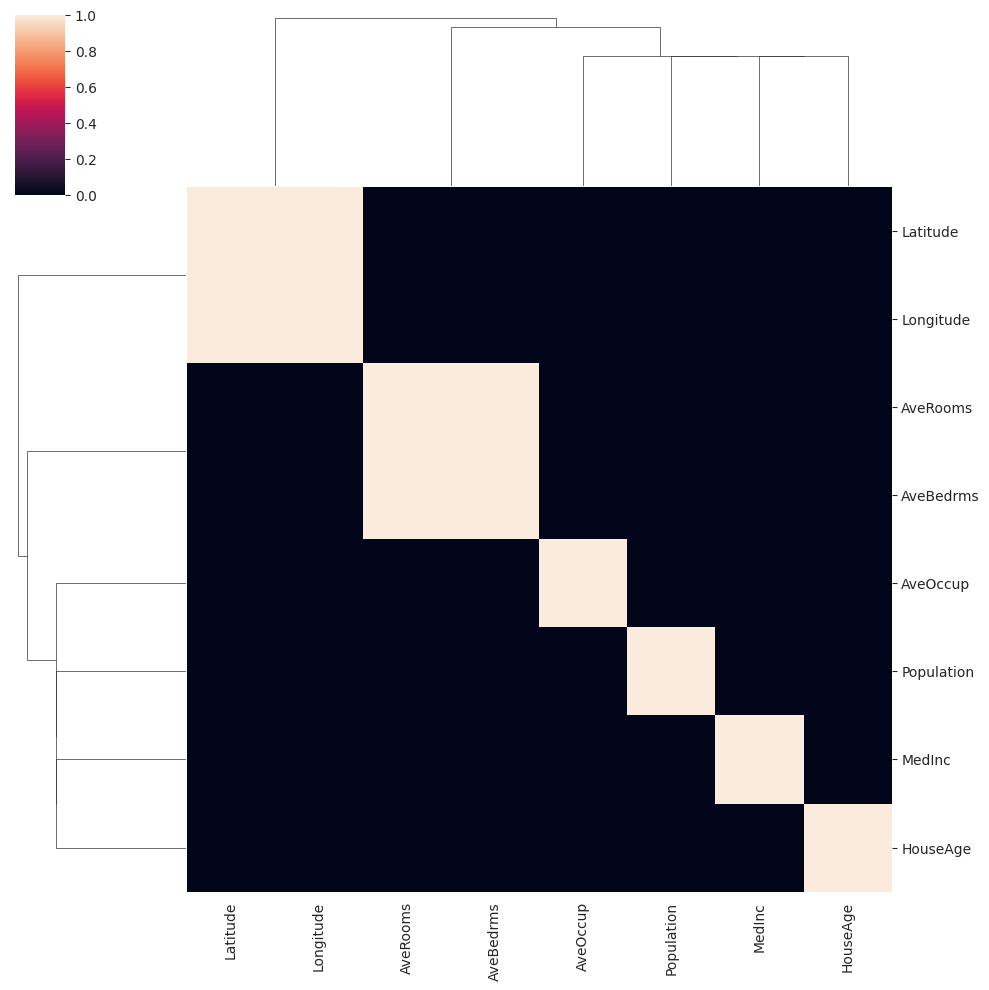

In [46]:
sns.clustermap(X_exp_train.corr().abs()>0.5);

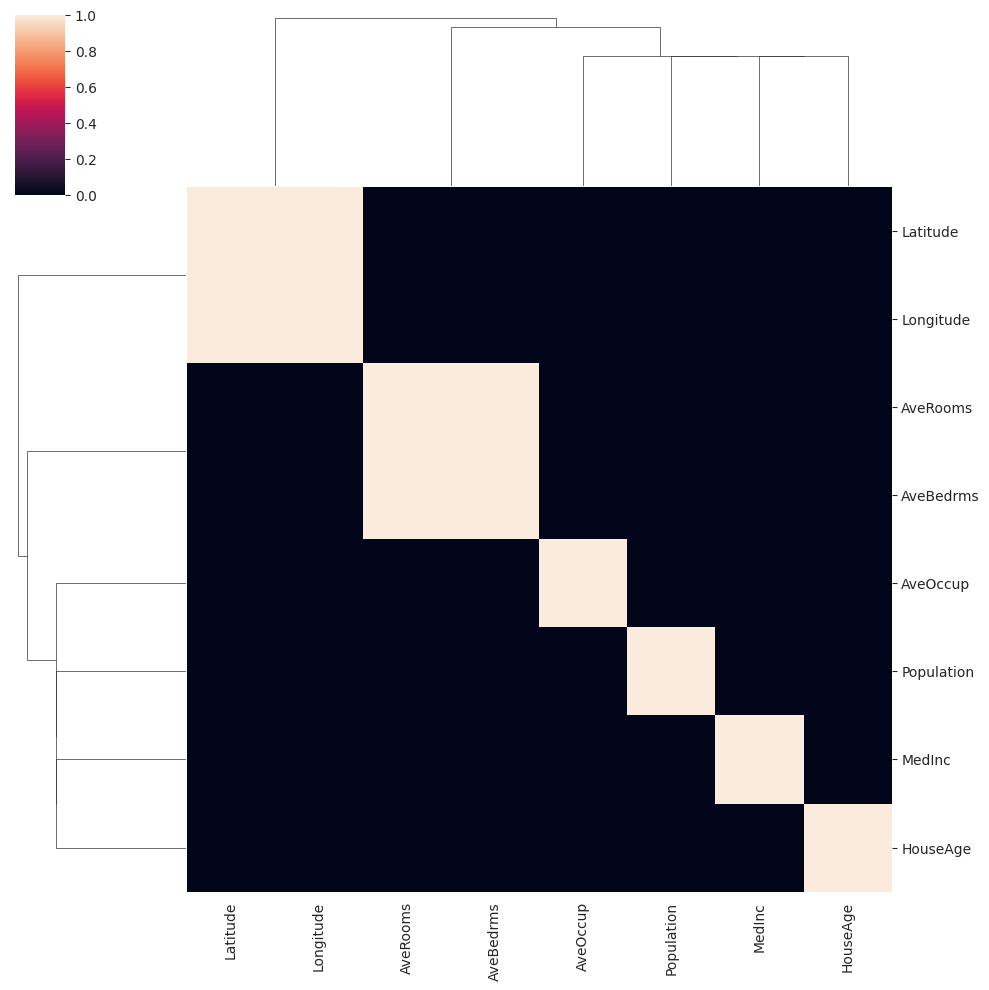

In [47]:
sns.clustermap(X_cheap_train.corr().abs()>0.5);

Картина прежняя. Стандартизуем и строим модель сначала без деления, потом с делением по цене.

In [48]:
lm_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lm", LinearRegression())
])

In [49]:
lm_pipeline.fit(X_train, y_train)
lm_pipeline.score(X_train, y_train)
r_sq = lm_pipeline.score(X_test, y_test)
mse_val = mean_squared_error(y_test, lm_pipeline.predict(X_test))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5961285884453014
MSE = 0.5405661575783066
[ 0.82824232  0.12153239 -0.26117647  0.30524043 -0.00653505 -0.03964943
 -0.888757   -0.85848682]


В первом приближении модель выглядит посредственно.

Посмотрим на коэффициенты регрессии в первой модели.

Для четвертого и пятого признаков значения коэффициентов малы. Попробуем удалить 4-ую фичу, посмотрим, что станет с моделью и коэффициентами.

In [50]:
X_train.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]
# Убираем переменную "население"

'Population'

In [51]:
left_ficha = X_train.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]

In [52]:
X_train2 = X_train.loc[:, X_train.columns != left_ficha]
X_test2 = X_test.loc[:, X_test.columns != left_ficha]
lm_pipeline.fit(X_train2, y_train)
lm_pipeline.score(X_test2, y_test)
r_sq = lm_pipeline.score(X_test2, y_test)
mse_val = mean_squared_error(y_test, lm_pipeline.predict(X_test2))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5961854263501958
MSE = 0.5404900822558786
[ 0.82840474  0.12370638 -0.26047923  0.30507995 -0.0401776  -0.8868674
 -0.85709544]


Пробуем убрать 5-ю фичу.

In [53]:
X_train2.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]
# Убираем переменную "AveOccup"

'AveOccup'

In [54]:
left_ficha = X_train2.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]
X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
lm_pipeline.fit(X_train3, y_train)
lm_pipeline.score(X_test3, y_test)
r_sq = lm_pipeline.score(X_test3, y_test)
mse_val = mean_squared_error(y_test, lm_pipeline.predict(X_test3))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5951882589741517
MSE = 0.5418247519589298
[ 0.82578726  0.12272241 -0.25704803  0.30246433 -0.89107813 -0.86100516]


Стало чуть хуже. Возвращаемся к идее второй модели.

In [55]:
lm_pipeline.fit(X_train2, y_train)
lm_pipeline.steps[1][1].coef_

array([ 0.82840474,  0.12370638, -0.26047923,  0.30507995, -0.0401776 ,
       -0.8868674 , -0.85709544])

Наиболее сильное влияние на модель оказывали первая, предпоследняя и последняя фичи (возраст дома и его географическое положение).
Поэкспериментируем, и попробуем создать модель только с ними.

In [56]:
X_train2.columns
new_cols = [X_train2.columns[i] for i in (0, len(X_train2.columns) - 1, len(X_train2.columns) - 2)]
X_train4 = X_train2.loc[:, new_cols]
X_test4 = X_test2.loc[:, new_cols]
lm_pipeline.fit(X_train4, y_train)
lm_pipeline.score(X_test4, y_test)
r_sq = lm_pipeline.score(X_test4, y_test)
mse_val = mean_squared_error(y_test, lm_pipeline.predict(X_test4))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5743861219840523
MSE = 0.5696676022831663
[ 0.70007378 -0.98622768 -1.02198585]


In [57]:
fitting = lm_pipeline.fit(X_train, y_train)
result = lm_pipeline.predict(X_test)
lm_pipeline.steps[1][1].coef_

array([ 0.82824232,  0.12153239, -0.26117647,  0.30524043, -0.00653505,
       -0.03964943, -0.888757  , -0.85848682])

Шалость не удалась. Возвращаемся к идее второй модели.

## С делением по цене

In [58]:
lm_pipeline.fit(X_exp_train, y_exp_train)
lm_pipeline.score(X_exp_train, y_exp_train)
r_sq = lm_pipeline.score(X_exp_test, y_exp_test)
mse_val = mean_squared_error(y_exp_test, lm_pipeline.predict(X_exp_test))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.0
MSE = 7.888609052210118e-31
[ 1.21009409e-31  4.23231811e-32 -2.45310582e-31  4.05573984e-31
 -3.75483126e-33  7.68785276e-32 -2.45198698e-30 -2.45878947e-30]


Модель для дорогих домов выглядит аномально-безнадежной -- предсказание константы.

In [60]:
lm_pipeline.fit(X_cheap_train, y_cheap_train)
lm_pipeline.score(X_cheap_train, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5685418024360289
MSE = 0.4114461269673957
[ 0.68295661  0.10344326 -0.26229291  0.28502952  0.00828447 -0.043914
 -0.79430174 -0.77727093]


Для дешевых домов все не так плохо. Поработаем с моделью дальше.

In [61]:
print("Убираем переменную", X_cheap_train.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))])
left_ficha = X_train.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]
X_cheap_train2 = X_cheap_train.loc[:, X_cheap_train.columns != left_ficha]
X_cheap_test2 = X_cheap_test.loc[:, X_cheap_test.columns != left_ficha]
lm_pipeline.fit(X_cheap_train2, y_cheap_train)
lm_pipeline.score(X_cheap_train2, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test2, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test2))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

Убираем переменную Population
R-square = 0.568638811137106
MSE = 0.4113536177635708
[ 0.68288678  0.10066323 -0.26334316  0.28532245 -0.04337827 -0.79663445
 -0.77892432]


На самую малость лучше.

In [62]:
print("Убираем переменную", X_cheap_train2.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))])
left_ficha = X_cheap_train2.columns[np.argmin(np.abs(lm_pipeline.steps[1][1].coef_))]
X_cheap_train3 = X_cheap_train2.loc[:, X_cheap_train2.columns != left_ficha]
X_cheap_test3 = X_cheap_test2.loc[:, X_cheap_test2.columns != left_ficha]
lm_pipeline.fit(X_cheap_train3, y_cheap_train)
lm_pipeline.score(X_cheap_train3, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test3, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test3))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

Убираем переменную AveOccup
R-square = 0.5702610833447532
MSE = 0.4098065904490086
[ 0.67884396  0.0995071  -0.2575945   0.28084976 -0.80120082 -0.78324235]


Еще немного лучше. Попробуем удалить что-то из фигурировавших переменных.

In [63]:
X_cheap_train3.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude'], dtype='object')

In [64]:
X_cheap_train4 = X_cheap_train3.loc[:, X_cheap_train3.columns != "AveRooms"]
X_cheap_test4 = X_cheap_test3.loc[:, X_cheap_test3.columns != "AveRooms"]
lm_pipeline.fit(X_cheap_train4, y_cheap_train)
lm_pipeline.score(X_cheap_train4, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test4, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test4))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5641835835140188
MSE = 0.4156022011967449
[ 0.57291014  0.09863732  0.0641172  -0.90534063 -0.87053439]


In [65]:
X_cheap_train4 = X_cheap_train3.loc[:, X_cheap_train3.columns != "AveBedrms"]
X_cheap_test4 = X_cheap_test3.loc[:, X_cheap_test3.columns != "AveBedrms"]
lm_pipeline.fit(X_cheap_train4, y_cheap_train)
lm_pipeline.score(X_cheap_train4, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test4, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test4))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.5604796177953237
MSE = 0.419134368062461
[ 0.56071506  0.09694853  0.02729445 -0.8950466  -0.85944715]


In [66]:
X_cheap_train4 = X_cheap_train3.loc[:, X_cheap_train3.columns != "Latitude"]
X_cheap_test4 = X_cheap_test3.loc[:, X_cheap_test3.columns != "Latitude"]
lm_pipeline.fit(X_cheap_train4, y_cheap_train)
lm_pipeline.score(X_cheap_train4, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test4, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test4))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.48105543430273834
MSE = 0.4948746665898215
[ 0.86882512  0.17312995 -0.54741458  0.47953931 -0.04384765]


In [67]:
X_cheap_train4 = X_cheap_train3.loc[:, X_cheap_train3.columns != "Longitude"]
X_cheap_test4 = X_cheap_test3.loc[:, X_cheap_test3.columns != "Longitude"]
lm_pipeline.fit(X_cheap_train4, y_cheap_train)
lm_pipeline.score(X_cheap_train4, y_cheap_train)
r_sq = lm_pipeline.score(X_cheap_test4, y_cheap_test)
mse_val = mean_squared_error(y_cheap_test, lm_pipeline.predict(X_cheap_test4))
coeffs = lm_pipeline.steps[1][1].coef_
print(f"R-square = {r_sq}\nMSE = {mse_val}\n{coeffs}")

R-square = 0.48548957548392113
MSE = 0.4906461915585786
[ 0.85126861  0.17868182 -0.50558168  0.44554669 -0.04642293]


In [68]:
X_train2.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude',
       'Longitude'],
      dtype='object')

In [69]:
X_cheap_train4.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude'], dtype='object')

Резюме: для общей выборки хороша вторая модель, для дешевых домов -- третья.

Наиболее ценные параметры для общей модели: MedInc, Latitude и Longitude\n
Для "дешевой" модели -- MedInc

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [70]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)

    return 1/(1 + np.exp(1)**(-1*output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [71]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    bce_value = (-1 / n) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return(bce_value)
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    grad = np.transpose(X) @ (y_pred - y_true)
    return grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [72]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            y_pred = sigmoid(X_test @ self.W)

        return y_pred
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [73]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

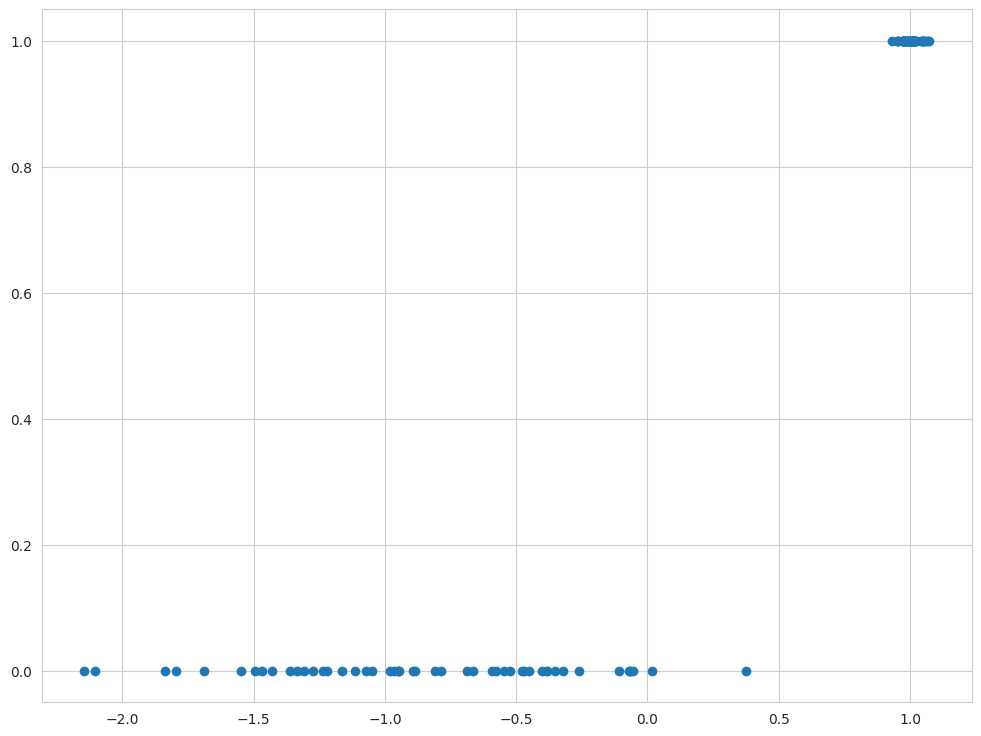

In [74]:
plt.scatter(X, y);

In [75]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

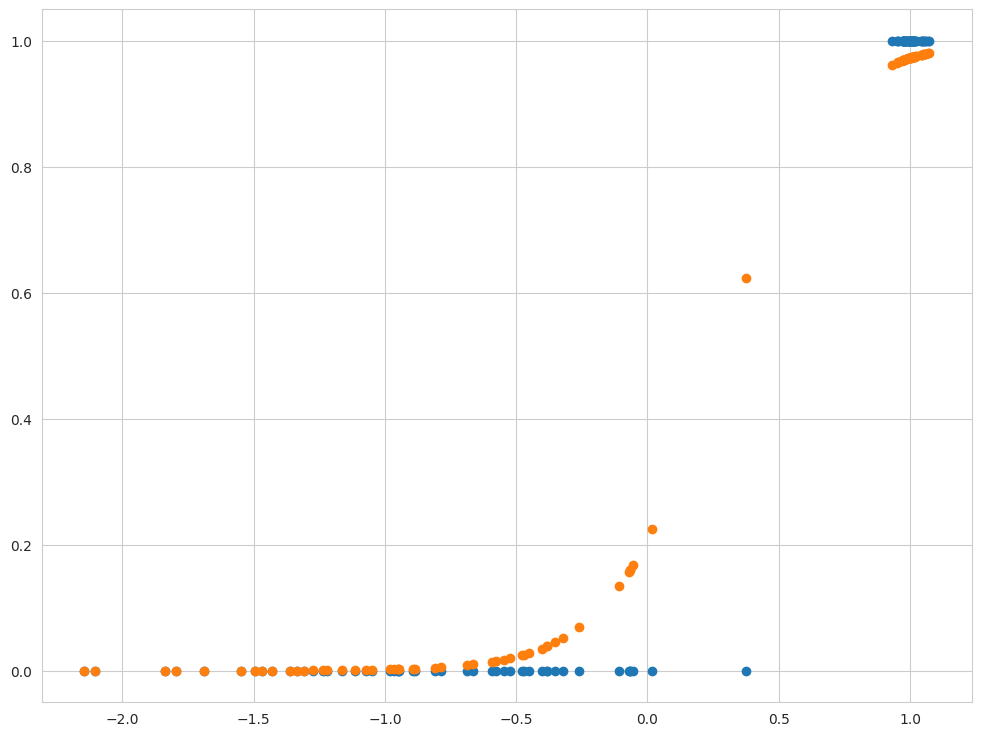

In [76]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [77]:
bce(y, y_pred)

232.08074834464568

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [79]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [80]:
# Посмотрим на данные
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [81]:
# И еще раз
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [82]:
# Поищем NA
np.sum(pokemon.isna())

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Много NA в колонке ```Type 2```

In [83]:
# Насколько сильно переменные скоррелированы
pokemon.corr(numeric_only=True)

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,1.000000,0.119813,0.097614,0.102298,0.094786,0.088759,0.085817,0.010733,0.982516,0.153396
Total,0.119813,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758
HP,0.097614,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.102298,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.094786,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.088759,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.085817,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.010733,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.982516,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.153396,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


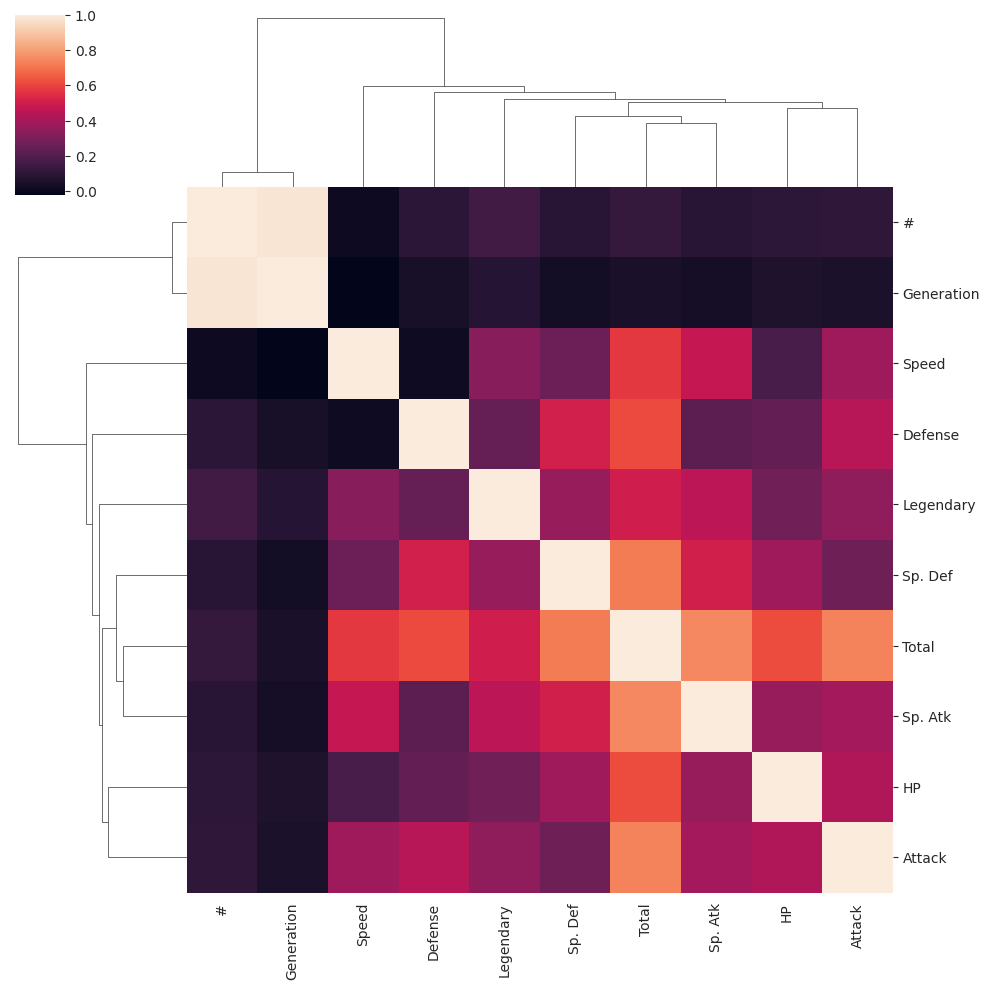

In [84]:
# Построим кластермэп
sns.clustermap(pokemon.corr(numeric_only=True));

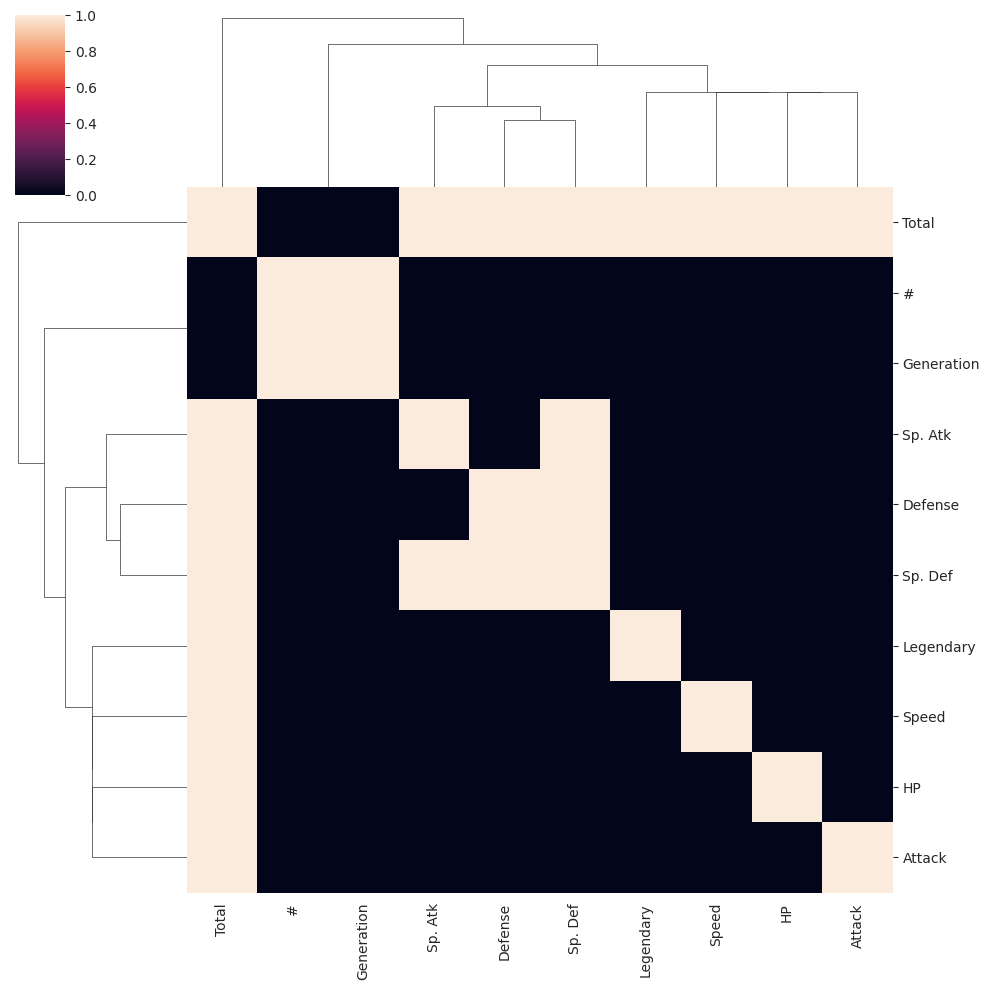

In [85]:
# Выделим переменные, у которых коэффициент корреляции больше, чем 0.5
sns.clustermap(pokemon.corr(numeric_only=True).abs()>0.5);

Специальная защита выглядит как первый кандидат на исключение из-за сильной скоррелированности с обычной защитой и специальной атакой. Но сначала построим полную модель.

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

Имеем три строковых переменных. Для начала проверим, является ли имя уникальным покемонимом или классовым именем.

In [86]:
len(set(pokemon["Name"]))/len(pokemon)

1.0

Это уникальный покемоним. Долой из предикторов!

In [87]:
print(len(set(pokemon["Type 1"])), len(set(pokemon["Type 2"])))
# Имеем 18 классов плюс NA 
# Кодировать нерационально, но можно создать новую переменную, которая определяет, есть ли у покемона второй класс.

18 19


In [88]:
pokemon["Types"] = pokemon.loc[:,"Type 2"].isna().astype("int") # Два класса кодируются нулем, один -- единицей
pokemon_new = pokemon.loc[:, ["#", "Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Generation", "Types", "Legendary"]]
pokemon_new

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Types,Legendary
0,1,318,45,49,49,65,65,45,1,0,False
1,2,405,60,62,63,80,80,60,1,0,False
2,3,525,80,82,83,100,100,80,1,0,False
3,3,625,80,100,123,122,120,80,1,0,False
4,4,309,39,52,43,60,50,65,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
795,719,600,50,100,150,100,150,50,6,0,True
796,719,700,50,160,110,160,110,110,6,0,True
797,720,600,80,110,60,150,130,70,6,0,True
798,720,680,80,160,60,170,130,80,6,0,True


In [89]:
# Разобьем данные на X и y
X_poc = pokemon_new.loc[:, pokemon_new.columns != "Legendary"]
y_poc = pokemon_new["Legendary"].astype("int")

In [90]:
y_poc.value_counts()
# Пахнет дисбалансом классов

0    735
1     65
Name: Legendary, dtype: int64

In [91]:
# Проверим, совпадает ли количество наблюдений у целевой переменной и признаков
X_poc.shape[0] == y_poc.shape[0]

True

Разделите ваши данные на тестовую и тренировочную выборку.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_poc, y_poc, test_size=0.2, random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [93]:
# Построим пайплайн
log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression())
])

In [94]:
log_reg_pipeline.fit(X_train, y_train)
log_reg_pipeline.score(X_test, y_test)

0.93125

In [95]:
log_loss(y_test, log_reg_pipeline.predict(X_test))

2.4780011705018046

In [96]:
log_reg_pipeline.steps[1][1].coef_
# Коэффициенты выглядят достаточно солидно

array([[ 1.72903439,  1.16742071,  0.32714069,  0.32199747,  0.84425   ,
         1.02228855,  0.96580025,  1.14533629, -0.65495309,  0.49225626]])

Из-за дисбаланса классов нам не вполне подходит accuracy. Логичнее использовать recall, чтобы не пропустить легендарных покемонов.

In [98]:
from sklearn.metrics import recall_score

In [99]:
recall_score(y_test, log_reg_pipeline.predict(X_test))

0.5

Recall достаточно скромный. Поэкспериментируем с моделью.

In [100]:
for ficha in X_train.columns:
    left_ficha = ficha
    X_train2 = X_train.loc[:, X_train.columns != left_ficha]
    X_test2 = X_test.loc[:, X_test.columns != left_ficha]
    log_reg_pipeline.fit(X_train2, y_train)
    score = log_reg_pipeline.score(X_test2, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test2))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test2))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.93125
BCE = 2.478001170501804
recall = 0.5
coefficients = [[1.19957659 0.35252173 0.35115338 0.84250694 1.01572004 1.00506581
  1.19292432 0.96300556 0.48486218]]


Without Total
score 0.93125
BCE = 2.4780011705018046
recall = 0.5
coefficients = [[ 1.73708439  0.56157579  0.62798407  1.1107435   1.29261012  1.20776282
   1.37981314 -0.68800916  0.47302142]]


Without HP
score 0.93125
BCE = 2.478001170501804
recall = 0.5
coefficients = [[ 1.74892389  1.59372816  0.26372668  0.73448052  0.91794798  0.89688615
   1.03498807 -0.6584542   0.47766165]]


Without Attack
score 0.925
BCE = 2.7032740041837866
recall = 0.5
coefficients = [[ 1.74395763  1.68719241  0.27010382  0.77398346  0.92674916  0.7821572
   1.07387233 -0.70533261  0.48373231]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[ 1.73906847  2.22215317  0.07483513  0.16421556  0.56187625  0.88837286
   0.72782258 -0.70484323  0.44411345]]


Without Sp. Atk
score 0.94375
BCE =

We have improved model by excluding Types and generation.\n
Now we will try again.

In [101]:
# Without types
X_train2 = X_train.loc[:, X_train.columns != "Types"]
X_test2 = X_test.loc[:, X_test.columns != "Types"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.13154526 0.32803271 0.32187181 0.80148863 0.88565372 0.95135724
  1.20993432 0.88657728]]


Without Total
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[ 1.72844317  0.51850159  0.58756691  1.04756767  1.15901333  1.14659863
   1.37048463 -0.76231556]]


Without HP
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[ 1.74206329  1.4811221   0.24990066  0.69756837  0.81397915  0.85154478
   1.04678139 -0.73623382]]


Without Attack
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[ 1.73147201  1.59254952  0.24597058  0.72373924  0.80114126  0.7486753
   1.07940332 -0.78070898]]


Without Defense
score 0.93125
BCE = 2.4780011705018046
recall = 0.5
coefficients = [[ 1.73800599  2.08415303  0.0672705   0.14123839  0.48609838  0.84418046
   0.7577853  -0.7843826 ]]


Without Sp. Atk
score 0.95
BCE 

In [102]:
# Without Generation
X_train2 = X_train.loc[:, X_train.columns != "Generation"]
X_test2 = X_test.loc[:, X_test.columns != "Generation"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.91875
BCE = 2.9285468378657686
recall = 0.4444444444444444
coefficients = [[1.11488495 0.41243982 0.25433274 0.75394606 1.03194531 0.89515097
  1.08667393 0.39960949]]


Without Total
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[1.1580974  0.57187312 0.67177272 1.13751152 1.31080815 1.25788957
  1.4257938  0.49196524]]


Without HP
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[1.19954476 1.62962503 0.29863806 0.75238687 0.92889537 0.93829848
  1.07066606 0.49659912]]


Without Attack
score 0.93125
BCE = 2.478001170501804
recall = 0.5555555555555556
coefficients = [[1.1476706  1.77727687 0.27010681 0.78751416 0.9280736  0.80561561
  1.10671851 0.50355153]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[1.14233337 2.27359677 0.07881515 0.19965783 0.56343556 0.93717803
  0.76212875 0.46573358]]


Without Sp. Atk
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555

There are no any difference. So, I try to delete Types and Generation both.

In [103]:
X_train2 = X_train.loc[:, X_train.columns != "Types"]
X_test2 = X_test.loc[:, X_test.columns != "Types"]
X_train2 = X_train2.loc[:, X_train2.columns != "Generation"]
X_test2 = X_test2.loc[:, X_test2.columns != "Generation"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.91875
BCE = 2.9285468378657686
recall = 0.5
coefficients = [[1.06749691 0.40662117 0.21958072 0.7164695  0.92307446 0.86766582
  1.12523203]]


Without Total
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[1.07506408 0.52684192 0.63283446 1.07736427 1.1688546  1.19287093
  1.42060918]]


Without HP
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[1.11483159 1.51317616 0.28752146 0.71933742 0.81806802 0.88981024
  1.08818877]]


Without Attack
score 0.94375
BCE = 2.0274555031378396
recall = 0.5555555555555556
coefficients = [[1.05897272 1.68624167 0.24436163 0.73909698 0.79110659 0.76792981
  1.11547386]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[1.06194337 2.1360097  0.06781276 0.17774068 0.47839341 0.88949047
  0.79560487]]


Without Sp. Atk
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.09953037 2.49455111 0.04598164 0

In [104]:
X_train2 = X_train.loc[:, X_train.columns != "Types"]
X_test2 = X_test.loc[:, X_test.columns != "Types"]
X_train2 = X_train2.loc[:, X_train2.columns != "Generation"]
X_test2 = X_test2.loc[:, X_test2.columns != "Generation"]
X_train2 = X_train2.loc[:, X_train2.columns != "Sp. Atk"]
X_test2 = X_test2.loc[:, X_test2.columns != "Sp. Atk"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.91875
BCE = 2.9285468378657686
recall = 0.3888888888888889
coefficients = [[ 2.6996244   0.07633195 -0.15284455  0.14452944  0.51922005  0.79373134]]


Without Total
score 0.93125
BCE = 2.4780011705018046
recall = 0.4444444444444444
coefficients = [[1.17919359 0.64195237 0.84416014 0.70134656 1.34948634 1.60846535]]


Without HP
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.10062267 2.53949413 0.03503266 0.25754185 0.66960773 0.9174507 ]]


Without Attack
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.0928939  2.54639829 0.04173361 0.26566085 0.65742131 0.92455595]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[ 1.0792374   2.69031116 -0.02092418  0.02386467  0.69730407  0.78738469]]


Without Sp. Def
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[ 1.01666497  3.27579634 -0.09289799 -0.35147234  0.27155537  0.63688263]]


Without Speed
sc

In [105]:
X_train2 = X_train.loc[:, X_train.columns != "Types"]
X_test2 = X_test.loc[:, X_test.columns != "Types"]
X_train2 = X_train2.loc[:, X_train2.columns != "Generation"]
X_test2 = X_test2.loc[:, X_test2.columns != "Generation"]
X_train2 = X_train2.loc[:, X_train2.columns != "Sp. Atk"]
X_test2 = X_test2.loc[:, X_test2.columns != "Sp. Atk"]
X_train2 = X_train2.loc[:, X_train2.columns != "HP"]
X_test2 = X_test2.loc[:, X_test2.columns != "HP"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.91875
BCE = 2.9285468378657686
recall = 0.3888888888888889
coefficients = [[ 2.78570955 -0.1679855   0.11882938  0.5003199   0.75916273]]


Without Total
score 0.91875
BCE = 2.9285468378657686
recall = 0.3333333333333333
coefficients = [[1.24567748 1.03784041 0.64075433 1.40311968 1.57787012]]


Without Attack
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.09456934 2.58178208 0.25611028 0.65115142 0.91105039]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[1.07862253 2.67213854 0.02640118 0.70243258 0.79304511]]


Without Sp. Def
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[ 1.01338103  3.20515343 -0.34980615  0.29324979  0.6640393 ]]


Without Speed
score 0.9375
BCE = 2.252728336819822
recall = 0.4444444444444444
coefficients = [[ 1.02897171  3.27294262 -0.12531877 -0.11731777  0.35385028]]




In [106]:
X_train2 = X_train.loc[:, X_train.columns != "Types"]
X_test2 = X_test.loc[:, X_test.columns != "Types"]
X_train2 = X_train2.loc[:, X_train2.columns != "Generation"]
X_test2 = X_test2.loc[:, X_test2.columns != "Generation"]
X_train2 = X_train2.loc[:, X_train2.columns != "Sp. Atk"]
X_test2 = X_test2.loc[:, X_test2.columns != "Sp. Atk"]
X_train2 = X_train2.loc[:, X_train2.columns != "HP"]
X_test2 = X_test2.loc[:, X_test2.columns != "HP"]
X_train2 = X_train2.loc[:, X_train2.columns != "Attack"]
X_test2 = X_test2.loc[:, X_test2.columns != "Attack"]
for ficha in X_train2.columns:
    left_ficha = ficha
    X_train3 = X_train2.loc[:, X_train2.columns != left_ficha]
    X_test3 = X_test2.loc[:, X_test2.columns != left_ficha]
    log_reg_pipeline.fit(X_train3, y_train)
    score = log_reg_pipeline.score(X_test3, y_test)
    bce = log_loss(y_test, log_reg_pipeline.predict(X_test3))
    recall = recall_score(y_test, log_reg_pipeline.predict(X_test3))
    coeffs = log_reg_pipeline.steps[1][1].coef_
    print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without #
score 0.925
BCE = 2.703274004183786
recall = 0.3888888888888889
coefficients = [[2.57981712 0.11976478 0.58616225 0.78230793]]


Without Total
score 0.91875
BCE = 2.9285468378657686
recall = 0.3888888888888889
coefficients = [[1.05676748 0.91776241 1.07412973 1.86658805]]


Without Defense
score 0.9375
BCE = 2.252728336819822
recall = 0.5
coefficients = [[1.07412296 2.70351802 0.68803828 0.78861946]]


Without Sp. Def
score 0.9375
BCE = 2.252728336819822
recall = 0.4444444444444444
coefficients = [[1.05719458 2.86517123 0.33417316 0.67023739]]


Without Speed
score 0.9375
BCE = 2.252728336819822
recall = 0.4444444444444444
coefficients = [[ 1.04770599  3.13866436 -0.1237165   0.41790594]]




In [107]:
#The optimal model looks like:
X_train2 = X_train2.loc[:, ["#", "Speed", "Sp. Def", "Defense", "Total"]]
X_test2 = X_test2.loc[:, ["#", "Speed", "Sp. Def", "Defense", "Total"]]
log_reg_pipeline.fit(X_train2, y_train)
score = log_reg_pipeline.score(X_test2, y_test)
bce = log_loss(y_test, log_reg_pipeline.predict(X_test2))
recall = recall_score(y_test, log_reg_pipeline.predict(X_test2))
coeffs = log_reg_pipeline.steps[1][1].coef_
print(f"Without {left_ficha}\nscore {score}\nBCE = {bce}\nrecall = {recall}\ncoefficients = {coeffs}\n\n")

Without Speed
score 0.95
BCE = 1.8021826694558576
recall = 0.5555555555555556
coefficients = [[1.09456934 0.91105039 0.65115142 0.25611028 2.58178208]]




Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

* Ссылка на страницу не открывается.
Верная выглядит [вот так:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [108]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score

In [109]:
confusion_matrix(y_test, log_reg_pipeline.predict(X_test2))

array([[142,   0],
       [  8,  10]])

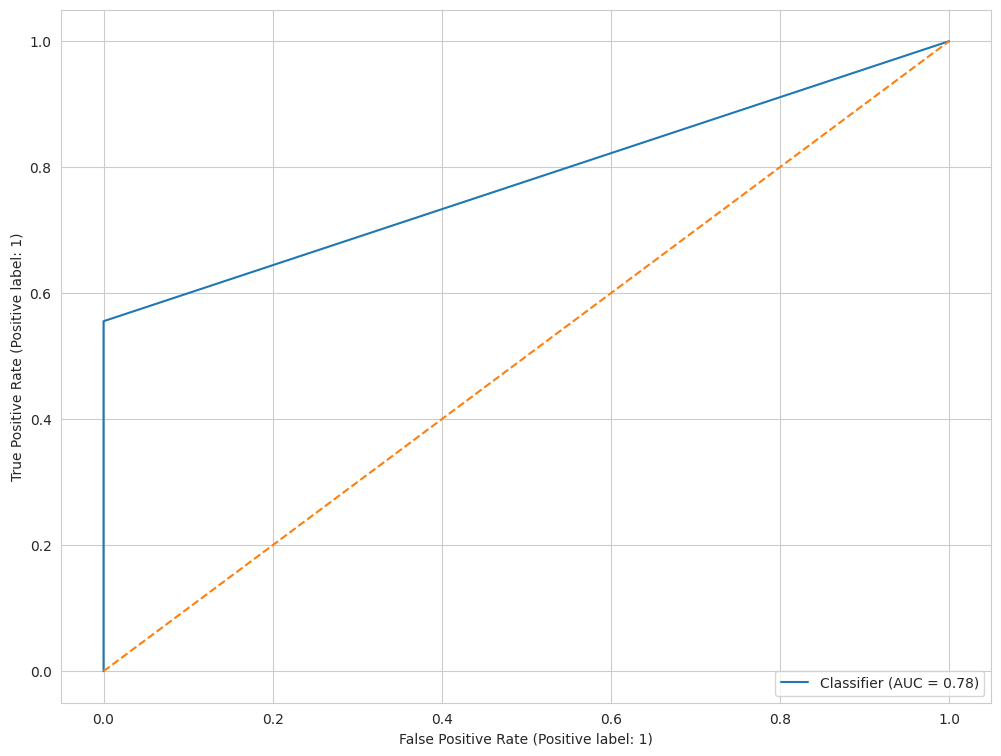

In [110]:
RocCurveDisplay.from_predictions(y_test, log_reg_pipeline.predict(X_test2));
plt.plot([0,1], "--");

In [111]:
print("AUC =", roc_auc_score(y_test, log_reg_pipeline.predict(X_test2)))

AUC = 0.7777777777777778


### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

БИ-2

Подробностей "знакомства", боюсь, что не вспомню. Подозреваю, что оно случилось после просмотра второй части "Брата", где одну из заглавных композиций исполняет вышеназванный коллектив.

Песни:
- Серебро
- Философский камень
- Черное солнце
- Полковнику никто не пишет
- Вечная, призрачная, встречная
- Летчик
- Того, что нет

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

- Как и в прошлый раз -- достаточно интересно, в меру сложно. Затруднения были по большей части методолгическими -- с одной стороны была мысль заморочиться и сделать подбор модели, как на статистике. С другой -- на лекциях упоминалось, что большинство ограничений, актуальных для статзадач, в МЛ не несут такой высокой смысловой нагрузки. 
- Понимаю, что это может быть очень трудновыполнимая хотелка (из-за большого количества студентов и малого -- преподавателей), но хотелось бы получать чуть более детальную обратную связь о косяках: как было правильно сделать в ошибочной ситуации (а иногда и не в ошибочной, если можно было реализовать лучше). Если бы подобное получилось, было бы очень здорово.